In [1]:
"""
주식데이터 추출 및 여론 조사

now_info = "현재가, 전일대비, 등락율"
total_news = 기업에 대한 최신 뉴스 5가지의 제목
information = 공시정보
total_review = 기업에 대한 최근 반응
"""

from IPython.display import display
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
from bs4 import BeautifulSoup

### 상장 중인 주식 정보 받아오기

In [2]:
# 상장중인 주식 정보 받아오기
finance_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]

#### 종목, 연도 입력 및 종목코드로 변환

In [3]:
# 종목 입력
keyword = input("원하는 종목명을 입력해주세요: ")

# 입력받은 종목을 받아온 주식 정보를 기반으로 종목코드로 변경
finance_num = str(finance_df[finance_df['회사명'] == keyword].values[0][1])

# 종목코드가 6개미만 숫자인 경우 앞부분에 0을 채워넣어줌
while not len(finance_num) == 6:
    finance_num = '0' + finance_num

# 주식 데이터를 가져올 시작 연도 입력
year = input("시작 연도를 입력해주세요: ")

원하는 종목명을 입력해주세요: 카카오
시작 연도를 입력해주세요: 2019


#### finance-reader 주식데이터 가져옴

In [4]:
# finance-reader를 통해 종목코드와 연도에 해당하는 주식 데이터 가져옴
df = fdr.DataReader(finance_num, year)

#### 5일, 20일, 60일, 120일 기준으로 평균내기

In [5]:
# 5일, 20일, 60일, 120일 기준으로 평균을 내서 데이터 삽입
ma_ls = [5, 20, 60, 120]
for i in range(4):
    a = df['Close'].rolling(window=ma_ls[i]).mean()
    df['MA' + str(ma_ls[i])] = a

#### 매일 장 마감 금액 및 5, 20, 60, 120일 평균 plot

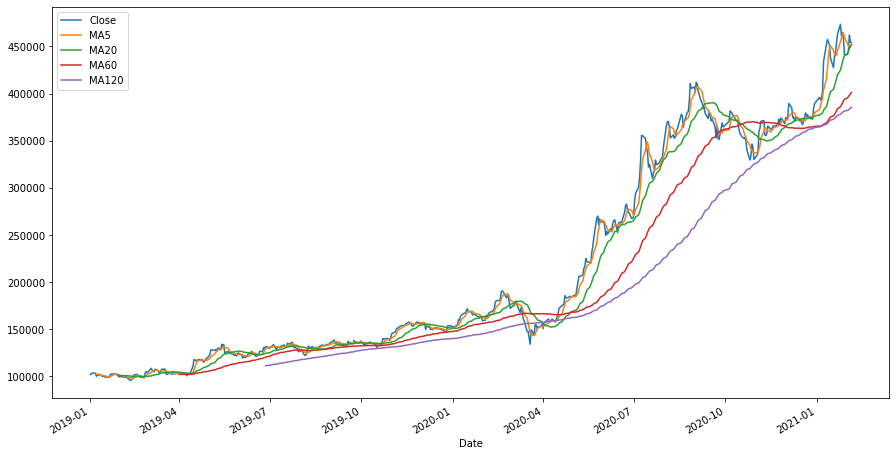

In [6]:
# plot
df.iloc[:, [3, 6, 7, 8, 9]].plot(figsize = (15, 8))

#### 실시간 주식 정보 크롤링

In [7]:
# 실시간 주식 정보
url = f'https://finance.naver.com/item/sise.nhn?code={finance_num}'

data = requests.get(url)
html = BeautifulSoup(data.text, "html.parser")

In [8]:
now_val = html.select('strong#_nowVal')[0].text

up_down = html.select('strong#_diff')[0].text.strip()
up_down = up_down.replace('하락', '-').replace('\n', '').replace('\t', '')
up_down = up_down.replace('상승', '+').replace('\n', '').replace('\t', '')

rate = html.select('strong#_rate')[0].text.strip()

now_info = pd.DataFrame({'현재가': [now_val],
                    '전일대비': [up_down],
                    '등락률': [rate]})
now_info.index = [keyword]

#### 최근 뉴스정보 크롤링

In [9]:
# 최근 뉴스정보
url = f'https://finance.naver.com/item/news_news.nhn?code={finance_num}&page=1&sm=title_entity_id.basic&clusterId='

data = requests.get(url)
html = BeautifulSoup(data.text, "html.parser")

total_news = pd.DataFrame({'날짜': [],
                           '제목': [],
                           '정보제공': []})

In [10]:
for i in range(5):
    news_title = html.select('td.title')[i].text.strip()
    news_info = html.select('td.info')[i].text.strip()
    news_date = html.select('td.date')[i].text.strip()
    total_news.loc[len(total_news)] = [news_date, news_title, news_info]

total_news.set_index('날짜', inplace=True)

#### 최근 공시정보 크롤링

In [11]:
# 최근 공시정보
url = f'https://finance.naver.com/item/news_notice.nhn?code={finance_num}&page=1'

data = requests.get(url)
html = BeautifulSoup(data.text, "html.parser")

information = pd.DataFrame({'날짜': [],
                           '공시정보': [],
                           '정보제공': []})

for i in range(3):
    info_date = html.select('td.date')[i].text.strip()
    info_title = html.select('td.title')[i].text.strip()
    info_info = html.select('td.info')[i].text.strip()
    information.loc[len(information)] = [info_date, info_title, info_info]

information.set_index('날짜', inplace=True)
    

#### 최근 여론 크롤링

In [12]:
# 여론조사
url = f'https://finance.naver.com/item/board.nhn?code={finance_num}&page=1'

header = {
    'referer' :f'https://finance.naver.com/item/board.nhn?code={finance_num}&page=2',
    'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.146 Safari/537.36'
}

data = requests.get(url, headers=header)
html = BeautifulSoup(data.text, "html.parser")

total_review = pd.DataFrame({'제목': [],
                            '닉네임': [],
                            '공감수': [],
                            '비공감수': []})

for i in range(0, 40, 2):
    total_review.loc[len(total_review)] = [html.select('td.title')[i // 2].text.strip().replace('\n','').replace('\t',''),
                                html.select('td.p11')[i // 2].text.strip(),
                                html.select('strong.tah')[i].text, html.select('strong.tah')[i + 1].text]

total_review.set_index('제목', inplace=True)
    

### 전체 출력

In [13]:
print()
print("--------------------------실시간 정보--------------------------")
display(now_info)
print()
print("---------------------------최근 뉴스---------------------------")
display(total_news)
print()
print("---------------------------공시 정보---------------------------")
display(information)
print()
print("---------------------------최근 반응---------------------------")
display(total_review)


--------------------------실시간 정보--------------------------


,현재가,전일대비,등락률
카카오,"454,000",-500,-0.11%



---------------------------최근 뉴스---------------------------


,제목,정보제공
날짜,,
2021.02.05 10:07,"카카오, OECD에 모바일 신분증 ‘카톡지갑’ 알렸다",파이낸셜뉴스
2021.02.05 09:42,"카카오, OECD 회의서 카카오워크·지갑·인증서 선봬",이데일리
2021.02.05 09:33,‘카카오 3총사’ OECD에 떴다!…카카오워크·카톡지갑·카카오 인증서...,헤럴드경제
2021.02.04 11:32,"금융위, 카카오·네이버 보험판매 직접규제",헤럴드경제
2021.02.04 09:30,"금융위, 네이버·카카오 보험판매 직접규제",헤럴드경제



---------------------------공시 정보---------------------------


,공시정보,정보제공
날짜,,
2021.01.26,(주)카카오 추가상장(국내CB전환),KOSCOM
2021.01.12,(주)카카오 추가상장(국내CB전환),KOSCOM
2021.01.12,(주)카카오 기업설명회(IR) 개최(안내공시),KOSCOM



---------------------------최근 반응---------------------------


,닉네임,공감수,비공감수
제목,,,
(긴급) 하신분들 보세요[2],nany****,3,1
막판에 밀어 올려줘요,ldse****,0,1
이거는 오늘 왜떨어지는거냐????,fbwl****,0,1
카카오 어제 오늘 완전 개판이다.,ginn****,0,2
힘좀 내자...다음주 월요일이 기대된다.[1],hjy8****,1,1
449500일때 추매 못한 사람[2],rlad****,5,2
지금이 마지막 기회이다[1],kimh****,1,1
보합만.... 양봉만......,zzan****,0,1
기관 외국인 국민연금 담기시작했내,kyi1****,0,1
